#### Book recommendations - „I like Lord of the Rings, what else should I read?“ 

In [ ]:
from data_scripts.utils import * 

###### CONFIG

In [3]:
# Direction for input csv files 
users_dir='data_scripts/BX-Users.csv'
books_dir='data_scripts/BX-Books.csv'
ratings_dir='data_scripts/BX-Book-Ratings.csv'

NameOfBookToRecommend='The Lord of the Rings'
NumberOfRecommendationForEachmethod=30

sentence_num=0
BERT_huge_model_name='bert-base-multilingual-uncased' #'bert-base-uncased'  'bert-base-multilingual-uncased' multilingual takes much more time to get embeddings
BERT_small_model_name='bert-base-nli-stsb-mean-tokens' #  this is model: bert-base-uncased

##### Functions

##### Preprocessing

In [5]:
# Users
df_users = import_csv( ['user_id', 'location', 'age'],users_dir)
#Books
df_books = import_csv( ['isbn', 'book_title' ,'book_author','year_of_publication', 'publisher', 'img_s', 'img_m', 'img_l'],books_dir)
#Ratings
df_ratings = import_csv(['user_id', 'isbn', 'rating'],ratings_dir)

In [6]:
# check dataframes correct encodings, descriptove statistics to get broad overview
describe_df(df_users)
describe_df(df_books)
describe_df(df_ratings)

,user_id,location,age
count,278858,278858,168096
unique,278858,57339,165
top,245704,"london, england, united kingdom",24
freq,1,2506,5687


,user_id,location,age
1,1,"nyc, new york, usa",NaN
2,2,"stockton, california, usa",18
3,3,"moscow, yukon territory, russia",NaN
4,4,"porto, v.n.gaia, portugal",17
5,5,"farnborough, hants, united kingdom",NaN


,isbn,book_title,book_author,year_of_publication,publisher,img_s,img_m,img_l
count,271379,271379,271378,271379,271377,271379,271379,271376
unique,271379,242154,102042,137,16824,271063,271063,271060
top,0553763067,Selected Poems,Agatha Christie,2002,Harlequin,http://images.amazon.com/images/P/067153145X.0...,http://images.amazon.com/images/P/006091291X.0...,http://images.amazon.com/images/P/051513449X.0...
freq,1,27,632,17627,7535,2,2,2


,isbn,book_title,book_author,year_of_publication,publisher,img_s,img_m,img_l
1,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
2,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
3,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
4,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
5,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


,user_id,isbn,rating
count,1149780,1149780,1149780
unique,105283,340556,11
top,11676,0971880107,0
freq,13602,2502,716109


,user_id,isbn,rating
1,276725,034545104X,0
2,276726,0155061224,5
3,276727,0446520802,0
4,276729,052165615X,3
5,276729,0521795028,6


(None, None)

###### Because we expect as input only a name of book we will use only Book titles and its ISBN as ID of a book, we also get explicitaly language of book by its reader location. 
###### All we see on the images is book titles, maybe different colors of book. In my opinion image vectorization is too abstract because we also expect imput recommendation for book which is not exactly same. Also different edition of books usually have different image in comparison to text where you always get same name in the beginning only edition maybe divergent. 
###### We will use following variables for our project:

In [7]:
df_users['location'] = df_users['location'].astype(str)
df_users['user_id'] = df_users['user_id'].astype(int)

df_books['isbn'] = df_books['isbn'].astype(str)
df_books['book_title'] = df_books['book_title'].astype(str)
                                                                      
df_ratings['user_id'] = df_ratings['user_id'].astype(int)
df_ratings['rating'] = df_ratings['rating'].astype(int)
df_ratings['isbn'] = df_ratings['isbn'].astype(str)

###### Remove not needed variables 

In [8]:
df_users = df_users[['user_id','location']]
df_books= df_books[['isbn','book_title']]
df_ratings= df_ratings[['user_id','rating','isbn']]

###### Get empty values for crucial columns 

In [9]:
#get_empty_byCol(df_users,'location')
#get_empty_byCol(df_users,'user_id')

#get_empty_byCol(df_books,'isbn')
#get_empty_byCol(df_books,'book_title')

#get_empty_byCol(df_ratings,'user_id')
#get_empty_byCol(df_ratings,'rating')
#get_empty_byCol(df_ratings,'user_id')

##### Connect all dataframes using User-ID and ISBN columns

In [10]:
df = pd.merge(df_ratings,df_users, on='user_id',how="inner")
df = pd.merge(df, df_books, on='isbn')
df.head(5)

,user_id,rating,isbn,location,book_title
0,276725,0,034545104X,"tyler, texas, usa",Flesh Tones: A Novel
1,2313,5,034545104X,"cincinnati, ohio, usa",Flesh Tones: A Novel
2,6543,0,034545104X,"strafford, missouri, usa",Flesh Tones: A Novel
3,8680,5,034545104X,"st. charles county, missouri, usa",Flesh Tones: A Novel
4,10314,9,034545104X,"beaverton, oregon, usa",Flesh Tones: A Novel


In [11]:
# get only countries
df['location']=[str(locat.split(',')[2]) for locat in df['location']]

# Because we recommend to english book we will choose only people from english countries 
#df['location'].unique()

countries = [' usa',' australia' ,' canada',' united kingdom',' united states']
df=df[df['location'].isin(countries)]
df = df.drop(['location'], axis = 1)

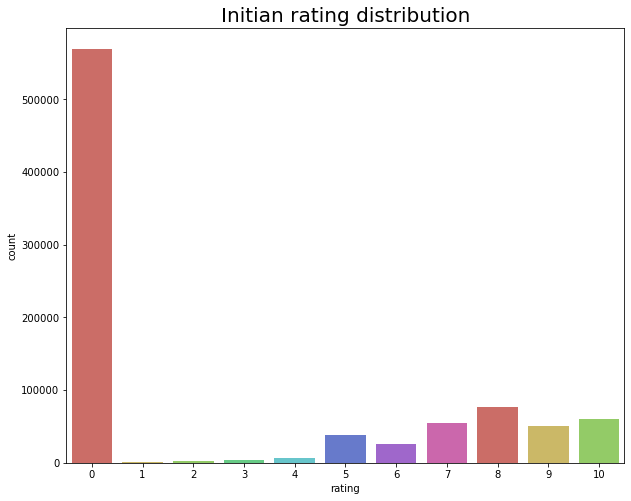

In [12]:
plot_column_distribution(df,'rating','Initian rating distribution')

###### We dont want our dataset to be sparse from the picture above we select rewievs with ranking higher than 4. 

In [13]:
df=df[df.rating>5].sort_values(by=['isbn'])

In [14]:
# create artificial isbn
lst=df['isbn'].unique()[0:len((df['book_title'].unique()))]
df=df.drop(['isbn'], axis = 1)
df_new_isbn=pd.DataFrame({'book_title': list(df['book_title'].unique()),'isbn': lst})
df=pd.merge(df, df_new_isbn, on='book_title')

# check same isbn for all titles
print("Is it true that len of unique book titles is same as len of unique isbn ? " + str (len(df['book_title'].unique())==len(df['isbn'].unique())))
df[df.book_title==NameOfBookToRecommend].sort_values(by=['user_id'])

Is it true that len of unique book titles is same as len of unique isbn ? True


,user_id,rating,book_title,isbn
38885,20172,10,The Lord of the Rings,0198323727
38886,22625,10,The Lord of the Rings,0198323727
38888,33030,10,The Lord of the Rings,0198323727
38889,73330,8,The Lord of the Rings,0198323727
38876,83186,10,The Lord of the Rings,0198323727
38873,85526,10,The Lord of the Rings,0198323727
38874,93092,10,The Lord of the Rings,0198323727
38882,94485,10,The Lord of the Rings,0198323727
38883,135149,10,The Lord of the Rings,0198323727
38881,142121,10,The Lord of the Rings,0198323727


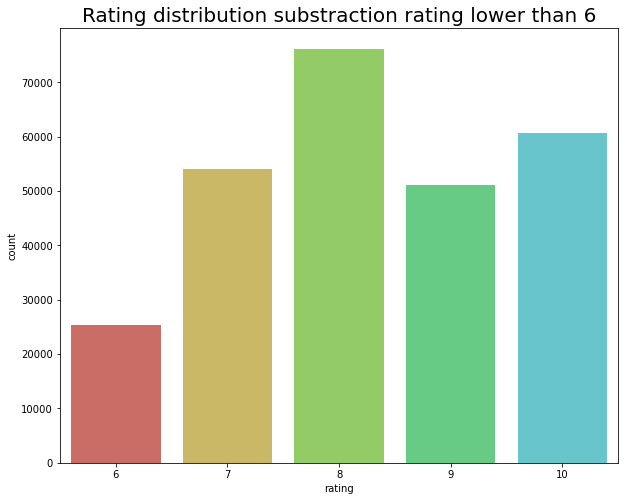

In [15]:
plot_column_distribution(df,'rating','Rating distribution substraction rating lower than 6')

In [16]:
# we take into consideration books only with more than 5 examples
df = df.groupby('user_id').filter(lambda x: len(x) >= 5)

In [17]:
df["user_id"]=df["user_id"].astype(int)

In [18]:
users = df["user_id"].unique().tolist()

In [19]:
df_titles=df['book_title'].unique()
len(df_titles)

85364

### Applying Bert to get embeddings - implicit solution on book titles

Bert has been applied with motifation to following articles [Universal Text Representation from BERT: An Empirical Study](https://arxiv.org/abs/1910.07973) and 
[BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding](https://arxiv.org/abs/1810.04805)

This takes about 12 minutes, so I skip embeddings and rather load already saved embeddings

In [20]:
#embeddings=get_embeddingsBert(df_titles)
# save data
#with open('embeddings_all.pkl', 'wb') as f:
#    pickle.dump(embeddings, f)

Time for creating 85364 embedding vectors 12.178525431950886
Model used :bert-base-nli-stsb-mean-tokens


In [25]:
# load embedings
with open('embeddings_all.pkl', 'rb') as f:
    embeddings=pickle.load(f)

In [26]:
embedding_eval=get_embeddingsBert([NameOfBookToRecommend])

Time for creating 1 embedding vectors 0.08507871230443319
Model used :bert-base-uncased


In [27]:
similarities=[cossim(embedding,embedding_eval[0]) for embedding in embeddings]

In [28]:
df_similarities_bert=pd.DataFrame({'title': list(df_titles)
                                     ,'similarity': similarities}).sort_values('similarity',ascending=False)
display(df_similarities_bert.head(NumberOfRecommendationForEachmethod))

,title,similarity
10132,The Lord of the Rings,0.321598
941,"The Lord of the rings,",0.319648
45948,The Lord of the Rings (Movie Art Cover),0.316528
13052,Valley of the Kings: A Novel of Tutankhamun,0.316039
54819,Lord of the Rings Trilogy,0.315825
58545,The Fellowship of the Ring Journal (The Lord o...,0.315770
69137,The Book of Kings,0.311663
27409,The Two Towers (Lord of the Rings (Hardcover)),0.311310
15682,The Return of the King (Lord of the Rings (Pap...,0.305638
42869,The Lord of the Rings (BBC Dramatization),0.305130


### Applying word2vec to get embeddings - explicit solution

For this explicit recommendation we are motivated by following article, we instead produts use books [Using Word2Vec Recommendation for Improved Purchase Prediction](https://ieeexplore.ieee.org/abstract/document/9206871)

In [29]:
books_ids_by_users=[(df[df["user_id"] == i]["isbn"].tolist(),) for i in users]

In [30]:
# create spark session  
if __name__ == "__main__":
                spark = SparkSession\
                    .builder\
                    .appName("Word2VecBooks")\
                    .getOrCreate()

In [31]:
df_users_ids = spark.createDataFrame(books_ids_by_users, ["sentence"])
word2Vec = Word2Vec(vectorSize=250,numPartitions=10,stepSize=0.03, seed=42, inputCol="sentence", outputCol="model",windowSize=7) 
model = word2Vec.fit(df_users_ids)
model.transform(df_users_ids)

DataFrame[sentence: array<string>, model: vector]

In [32]:
# I get here actually closest book "isbn" to recommendation string
book_isbn=df[df['book_title']==df_similarities_bert['title'].iloc[0]][['isbn']].iloc[0][0]

In [33]:
df_similarities_word2vec= model.findSynonymsArray(book_isbn,NumberOfRecommendationForEachmethod)

In [34]:
df_similarities_word2vec= pd.DataFrame(df_similarities_word2vec,columns=['isbn','similarity']).sort_values('similarity',ascending=False)

In [35]:
df_similarities_word2vec = pd.merge(df_similarities_word2vec, df_new_isbn, on='isbn')[['book_title','similarity']]

In [36]:
df_similarities_word2vec.head(NumberOfRecommendationForEachmethod)

,book_title,similarity
0,Straight Man : A Novel (Vintage Contemporaries),0.974101
1,Trunk Music (Detective Harry Bosch Mysteries),0.972699
2,Seabiscuit: An American Legend,0.970532
3,Rules of the Wild,0.969367
4,Thirty-nothing,0.967368
5,Little Girl Lost,0.966396
6,Therapy,0.965754
7,Falling Leaves: The True Story of an Unwanted ...,0.965713
8,The Stone Diaries,0.962909
9,Gorky Park,0.962350


### Conclusion and improvements

This was very interesting task for me which has led me to read some scientific articles to get the solutions. Bert and word2vec similarity has been used. Both evaluation in my opinion are very interesting but still given by absolutely different approach. Additional, I decided to use Spark because I did not work with it before and I wanted to learn it.

There is still so much work to think of. The similarities could been normalized and there would be a nice idea to create a hybrid model. Another crucial think would be testing. I would strongly suggest blind test for real world similar books to improve performance and much more!